# Cell type annotation and marker genes

In this notebook we generate figures illustrating the named clusters in different splits and the expression of marker genes

Manual annotations are saved in `Pan_fetal_immune/metadata/manual_annotations`.

Marker genes are saved in GDrive at `Pan_fetal/significant_genes/marker_genes`

In [339]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

In [520]:
import scvelo as scv
import seaborn as sns

In [340]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'
marker_genes_dir = "/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/marker genes/"

### Load collapsed annotation

Merging tables in `metadata/manual_annotation` with script `src/4_annotation/collapse_annotation.py`.

In [341]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.csv".format(t=timestamp), index_col=0)

keep_anno = ["LYMPHOID", 
             "MYELOID", 
             "MEM_PROGENITORS",
             "STROMA"
            ]

anno_lvl_1_cols = ["anno_lvl_1_" + x for x in keep_anno]
anno_lvl_2_cols = ["anno_lvl_2_" + x for x in keep_anno]

### Fix conflicts

fix conflicts with manual curation or assigning labels of closest nearest neighbors in full immune view.

In [341]:
## If annotation is unique, save as final
anno_obs["anno_lvl_2_final"] = np.nan
anno_obs.loc[(anno_obs["is_annotated"]==1) & (anno_obs["is_uniquely_annotated"]==1), "anno_lvl_2_final"] = anno_obs.loc[(anno_obs["is_annotated"]==1) & (anno_obs["is_uniquely_annotated"]==1), anno_lvl_2_cols].apply(lambda x: x[x.first_valid_index()], axis=1)

## Find cells with double annotation across multiple splits and save for manual revision
conflict_ixs = (anno_obs["is_annotated"]==1) & (anno_obs["is_uniquely_annotated"]==0)
double_anno_cells = anno_obs[conflict_ixs]
double_anno_cells[anno_lvl_1_cols].drop_duplicates().to_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/label_conflicts.csv")
double_anno_cells[anno_lvl_2_cols].drop_duplicates().to_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/label_conflicts_lvl2.csv")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [342]:
## Reload manual conflict fixes 
conflicts_fixed = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/label_conflicts_lvl2_fixed.csv", index_col=0)

anno_obs_conflicts = anno_obs[conflict_ixs]
anno_obs_conflicts = anno_obs_conflicts.drop(["anno_lvl_2_final"], 1)
anno_obs_conflicts = anno_obs_conflicts.merge(conflicts_fixed)
anno_obs_conflicts.index = anno_obs[conflict_ixs].index.copy()

anno_obs.loc[conflict_ixs, "anno_lvl_2_final"] = anno_obs_conflicts["anno_lvl_2_final"]

In [347]:
to_fix_ixs = anno_obs_conflicts[anno_obs_conflicts.anno_lvl_2_final.isna()].index

## Load adata with KNN graph for HSC_immune to fix conflicts based on nearest neighbors
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s="HSC_IMMUNE"), backed="r")
adata.var_names_make_unique()

anno_obs_hsc_immune = anno_obs.loc[adata.obs_names]
adata.obs = anno_obs_hsc_immune.copy()

## Find neighbors of cells with conflicting annotation
knn_graph = adata.obsp["scvi_connectivities"]
knn_graph_double = knn_graph[adata.obs_names.isin(double_anno_cells.index),:]
knn_graph_double[knn_graph_double.nonzero()] = 1

## Find most abundant cell label in neighbors
neighbors_labels = pd.DataFrame()
n_neighbors_labels = pd.DataFrame()

annos = adata.obs["anno_lvl_2_final"].copy()

dummy_df = pd.get_dummies(annos)
dummy_mat = scipy.sparse.csr_matrix(dummy_df)

new_anno = knn_graph_double.dot(dummy_mat).toarray()
if new_anno.shape[1]==0:
    best_label = np.nan
    n_cells_best_label = np.nan
else:
    best_label = dummy_df.columns[new_anno.argmax(1)]
    n_cells_best_label = new_anno.max(1)
neighbors_labels['anno_lvl_2_final']  = best_label
n_neighbors_labels['anno_lvl_2_final']  = n_cells_best_label

neighbors_labels.index = adata.obs_names[adata.obs_names.isin(double_anno_cells.index)]
anno_obs.loc[to_fix_ixs, "anno_lvl_2_final"] = neighbors_labels.loc[to_fix_ixs]["anno_lvl_2_final"]

In [348]:
anno_obs_hsc_immune = anno_obs.loc[adata.obs_names]
adata.obs = anno_obs_hsc_immune.copy()

... storing 'file' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical
... storing 'anno_lvl_1_LYMPHOID' as categorical
... storing 'anno_lvl_2_LYMPHOID' as categorical
... storing 'anno_lvl_1_MYELOID' as categorical
... storing 'anno_lvl_2_MYELOID' as categorical
... storing 'anno_lvl_1_MEM_PROGENITORS' as categorical
... storing 'anno_lvl_2_MEM_PROGENITORS' as categorical
... storing 'anno_lvl_2_final' as categorical


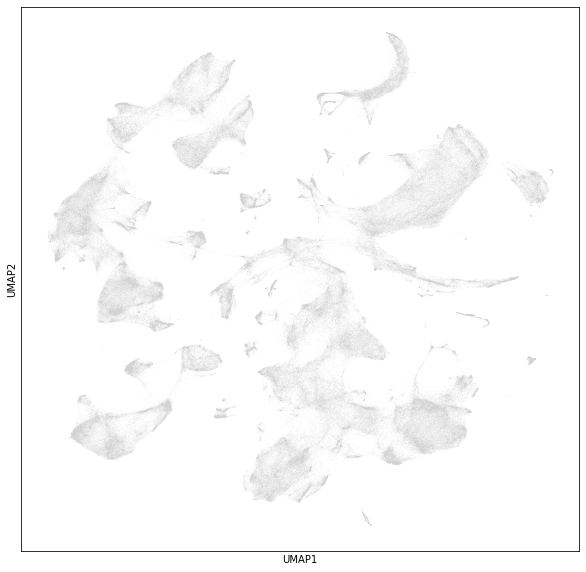

In [349]:
sc.pl.umap(adata)

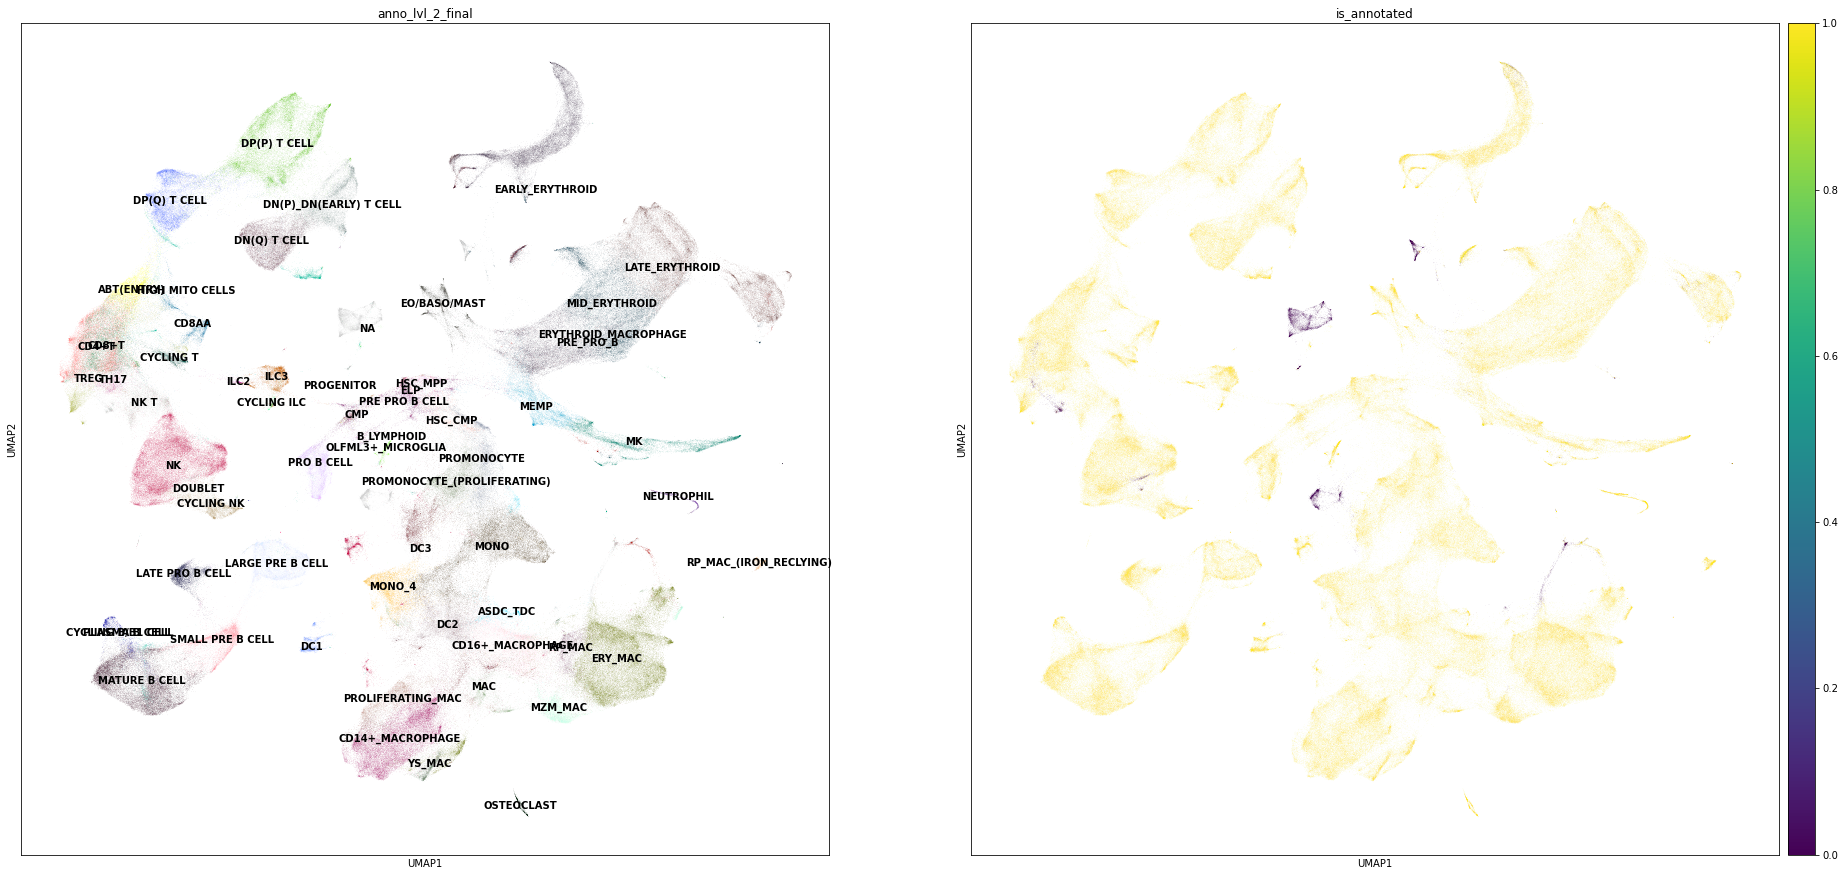

In [445]:
plt.rcParams['figure.figsize'] = [15,15]
sc.pl.umap(adata, color=['anno_lvl_2_final','is_annotated'], legend_loc="on data")

In [464]:
### Check the missing labels
# clusters_df = pd.read_csv(data_dir + "scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.HSC_IMMUNE.scVI_out.clustering.csv", index_col=0)

# adata.obs = pd.concat([adata.obs,clusters_df], 1)

# adata.obs[adata.obs["is_annotated"] == 0]["leiden_150"].value_counts()[0:10]

# adata.obs['leiden_150'] = adata.obs['leiden_150'].astype("category")
# sc.pl.umap(adata, color=['leiden_150'], size=5, groups=[41,42,27, 1, 46, 10, 3, 32],legend_loc="on data")

### Cleaning

In [486]:
import re

clean_anno = adata.obs["anno_lvl_2_final"].copy()
clean_anno = clean_anno.astype("str")
clean_anno[adata.obs["is_annotated"]==0] = "UNKNOWN"
clean_anno = [x.split(" CELL")[0] for x in clean_anno]
clean_anno = ["_".join(x.split(" ")) for x in clean_anno]
clean_anno = [re.sub("MAC$", "MACROPHAGE", x) for x in clean_anno]
clean_anno = pd.Series(clean_anno)

## Fix typos
typos = {
    'RP_MAC_(IRON_RECLYING)':'RP_MACROPHAGE_(IRON_RECYCLING)'
}

clean_anno = pd.Series([typos[x] if x in typos.keys() else x for x in clean_anno])

In [499]:
adata.obs["anno_lvl_2_final_clean"] = clean_anno.values

### Assign labels to groups
for plotting/summarisation

In [579]:
# for a in keep_anno:
#     print(anno_obs["anno_lvl_2_"+a].unique())
# ....
# ....

In [ ]:
anno_groups = {
    "NK/ILC/T CELLS" : [ "DN(P)_DN(EARLY)_T",  "DN(Q)_T", "DP(Q)_T" ,  "DP(P)_T", "ABT(ENTRY)", "CD4+T", "CD8+T", "CD8AA","TREG","TH17",  "NK_T", "NK", "ILCP","ILC2", "ILC3","CYCLING_ILC", "CYCLING_NK"],
    "B CELLS" :["PRE_PRO_B", "PRO_B","LATE_PRO_B", "PRO_TO_PRE_B","SMALL_PRE_B","LARGE_PRE_B", "PRE_B", "IMMATURE_B", "MATURE_B", "CYCLING_B/B1", "PLASMA_B"],
    "EO/BASO/MAST":["EO/BASO/MAST"],
    "MYELOID":[
    "PROMYELOCYTE","MYELOCYTE", "NEUTROPHIL",
    "MONO_MAC", "ERY_MAC", "KUPFFER", "LANGERHAN CELLS", "LYMPHOID_SCAVENGING_MAC","MAC", "MZM", "MZM_(BAFF)",
                   "RP_MAC", "STROMAL_MAC","PROMONOCYTE", "CD14_MONOCYTE",
    'PDC_PROGEN',"MYELOID_DC_PROGEN","DC_PROGEN","DC1", "DC2","DC3", "PDC"],
    "PROGENITORS" : ["HSC_MPP","CMP","MEMP","GMP","MPP_MYE","CLP", "ELP", "PROGENITOR"],
    "ERYTHROID":["EARLY_ERYTHROID","MID_ERYTHROID", "LATE_ERYTHROID","GOWER1_ERY"],
    "MK":["EARLY_MK","MK"]
    }

### Load marker genes

In [398]:
marker_genes_dir = '../../metadata/marker_genes/'
for file in [x for x in os.listdir(marker_genes_dir) if '09072021.csv' in x]:
    with open(marker_genes_dir + file) as f:
        header = f.readline().rstrip()
        if "cluster" in header:
            marker_df = pd.read_csv(marker_genes_dir + file).iloc[:,0:2]
            marker_df.columns = ["anno_lvl_2", "gene"]
            marker_df = marker_df[["gene", "anno_lvl_2"]] 
        else:
            marker_df = pd.read_csv(marker_genes_dir + file, header=None).iloc[:,0:2]
            marker_df.columns = ["gene", "anno_lvl_2"]
    marker_df["anno_lvl_2"] = marker_df["anno_lvl_2"].str.upper()
    marker_df.to_csv(marker_genes_dir + file.strip(".csv") + "_clean.csv")

In [539]:
filenames = [x for x in os.listdir(marker_genes_dir) if '_clean.csv' in x]
split_names = [x.split("_")[0] for x in filenames]
all_markers_ls = []
for i in range(len(filenames)):
    marker_df = pd.read_csv(marker_genes_dir + filenames[i], index_col=0)
    marker_df["split"] = split_names[i]
    all_markers_ls.append(marker_df)

In [556]:
all_markers_df = pd.concat(all_markers_ls, 0)
all_markers_df["anno_lvl_2"] = [x.split(" CELL")[0] for x in all_markers_df["anno_lvl_2"]]
all_markers_df["anno_lvl_2"] = ["_".join(x.split(" ")) for x in all_markers_df["anno_lvl_2"]]
all_markers_df["anno_lvl_2"] = [re.sub("MAC$", "MACROPHAGE", x) for x in all_markers_df["anno_lvl_2"]]

In [543]:
all_annos = pd.concat(all_markers_ls, 0)["anno_lvl_2"].unique()
all_annos[~pd.Series(all_annos).isin(adata.obs["anno_lvl_2_final"].unique())]

## Visualize clusters and markers
in lineage subsets

In [719]:
def _load_split(split, min_n_cells = 50):
    spl_adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))

    ## Save annotations for split
    spl_adata.obs["anno_lvl_2_final_clean"] = adata.obs.loc[spl_adata.obs_names]["anno_lvl_2_final_clean"].astype("str")

    ## Label as OTHER cell labels that appear in less than 50 cells
    small_labels = spl_adata.obs["anno_lvl_2_final_clean"].value_counts()[spl_adata.obs["anno_lvl_2_final_clean"].value_counts() < min_n_cells].index
    spl_adata.obs.loc[spl_adata.obs["anno_lvl_2_final_clean"].isin(small_labels), "anno_lvl_2_final_clean"] = "OTHER"
    return(spl_adata)

def _plot_marker_dotplot(spl_adata, mark_split, labels_order=None, gene_labels_order=None):
    markers_df = all_markers_df[all_markers_df["split"].isin(mark_split)]
    markers_df = markers_df[markers_df.gene.isin(spl_adata.var_names)]
    # markers_df = markers_df.sort_values('anno_lvl_2')
    if gene_labels_order is None:
        gene_labels_order = markers_df.anno_lvl_2.unique().tolist()

    markers_df= markers_df[markers_df.anno_lvl_2.isin(gene_labels_order)]
    markers_dict = {g: d['gene'].values.tolist() for g, d in markers_df.groupby('anno_lvl_2')}
    markers_dict = {k: markers_dict[k] for k in gene_labels_order}
    
    if labels_order is None:
        labels_order = gene_labels_order
    
    keep_labels = [x for x in labels_order if x in spl_adata.obs["anno_lvl_2_final_clean"].values]
    sc.pl.dotplot(spl_adata[spl_adata.obs["anno_lvl_2_final_clean"].isin(keep_labels)], 
                  markers_dict, 
                  groupby="anno_lvl_2_final_clean", 
                  categories_order=keep_labels)

def _plot_split_embedding(spl_adata, split):
    sns.set_context("talk")
    scv.pl.umap(spl_adata, color="anno_lvl_2_final_clean", legend_loc="on data", 
                size=2, legend_fontoutline=3,
                title=split)
    
def _plot_markers_embedding(spl_adata, mark_split, n_row=5, gene_labels_order = None):
    markers_df = all_markers_df[all_markers_df["split"].isin(mark_split)]
    markers_df = markers_df[markers_df.gene.isin(spl_adata.var_names)]
    # markers_df = markers_df.sort_values('anno_lvl_2')
    if gene_labels_order is None:
        gene_labels_order = markers_df.anno_lvl_2.unique().tolist()

    markers_df= markers_df[markers_df.anno_lvl_2.isin(gene_labels_order)]
    marker_genes = markers_df.gene.unique().tolist()

    n_genes=0
    for i in range(round(len(marker_genes)/n_row) + 1):
        n_genes_max = n_row*(1+i)
        if n_genes_max > len(marker_genes):
            n_genes_max = len(marker_genes)
        sns.set_context("talk")
        print(scv.pl.umap(spl_adata, color=marker_genes[n_genes:n_genes_max], size=5, fontsize=32, legend_fontsize=32))
        n_genes += n_row
        if n_genes >= len(marker_genes):
            break

### NKT cells

In [727]:
spl_adata = _load_split("NKT")

In [728]:
nkt_labels_order = [
    'HSC_MPP',
    'MEMP',
    'HSC_CMP',
    'ELP',
    'PROGENITOR',
    'CMP',
    'DN(P)_DN(EARLY)_T',
    'DP(Q)_T',
 'DN(Q)_T',
 'DP(P)_T',
 'CYCLING_T',
 'ABT(ENTRY)',
 'CD4+T',
 'CD8+T',
  'TH17',
 'CD8AA',
 'TREG',
'NK_T',
 'NK',
 'CYCLING_NK',
 'ILC3',
 'ILC2',
 'CYCLING_ILC',
 'HIGH_MITO',
 'UNKNOWN',
 'DOUBLET']
# spl_adata.obs["anno_lvl_2_final_clean"].unique().tolist()

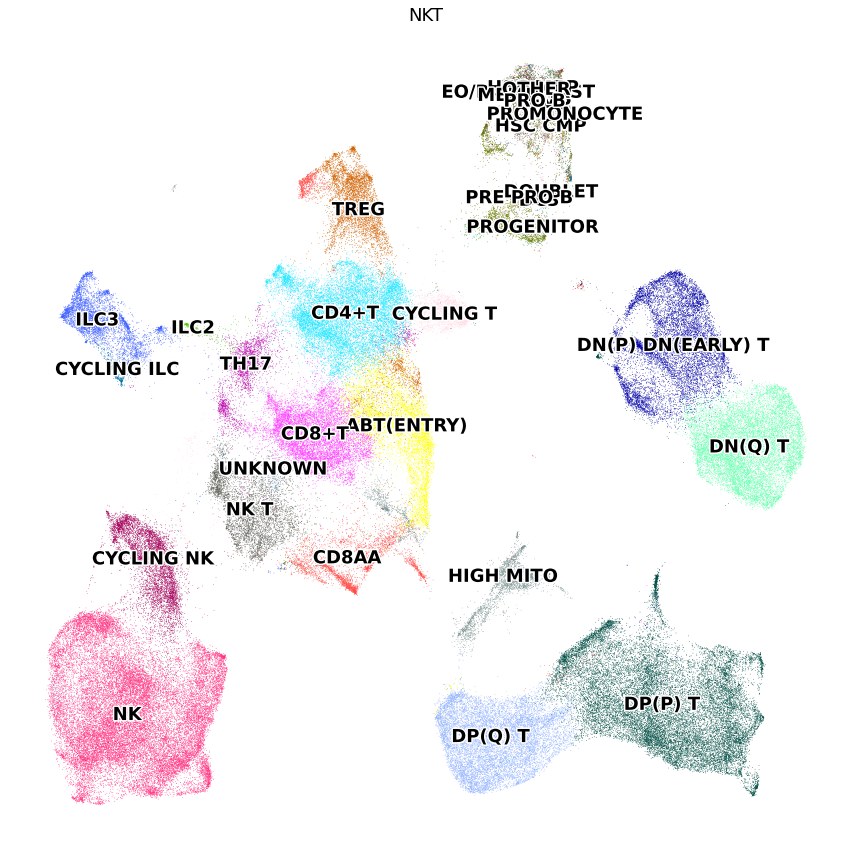

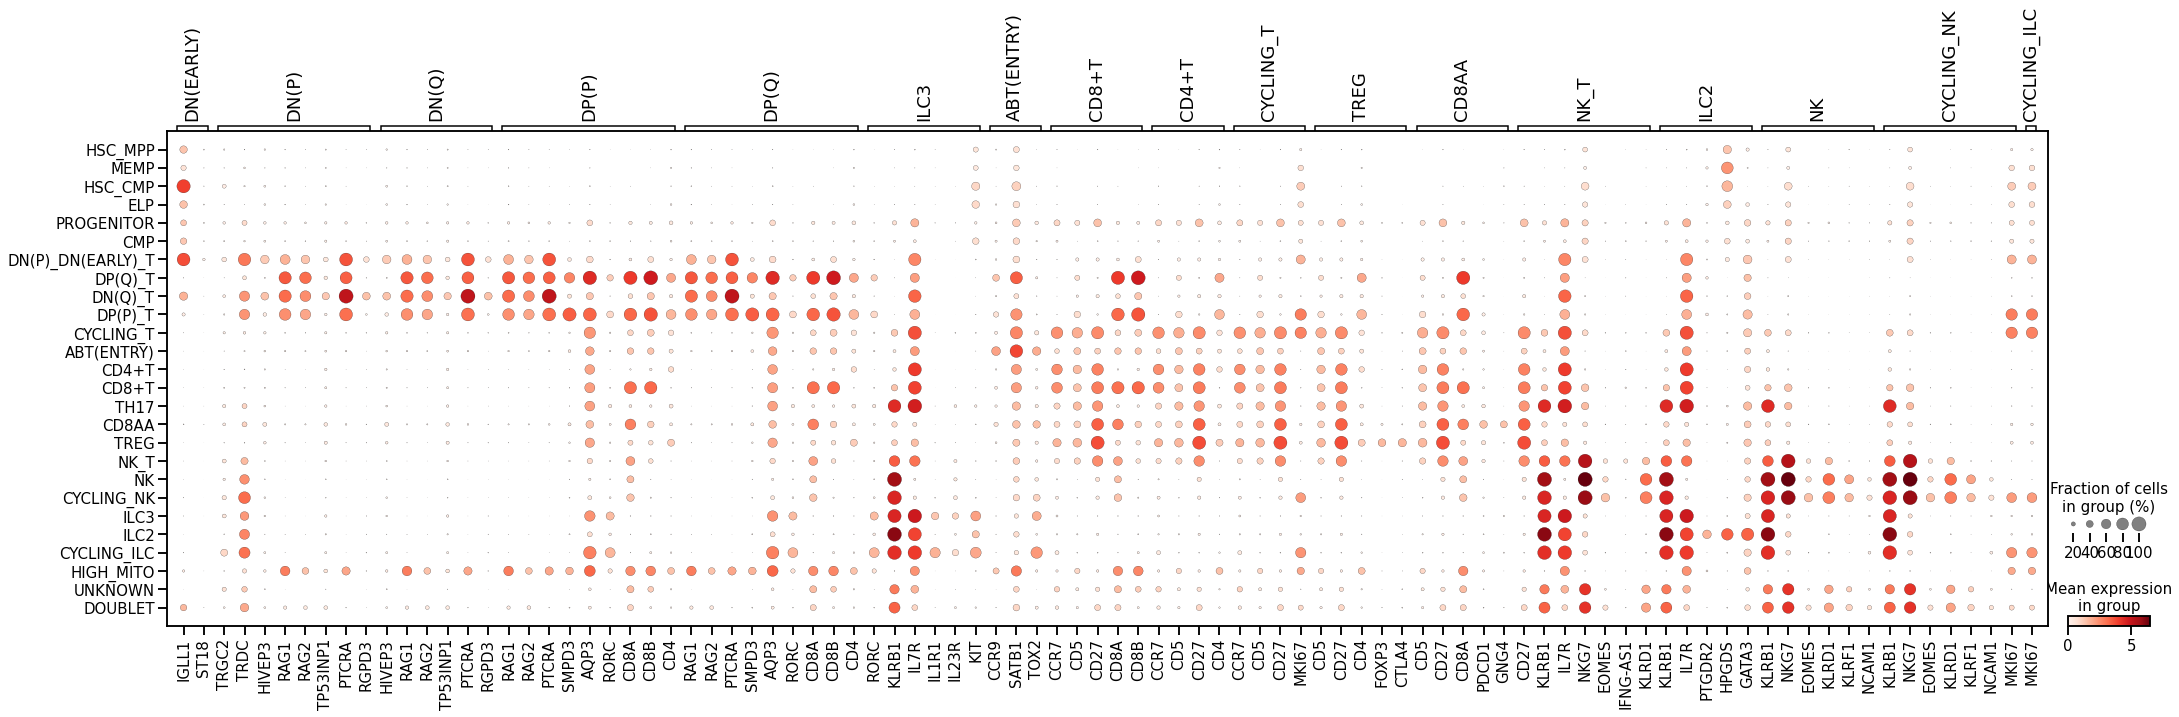

In [729]:
_plot_split_embedding(spl_adata, "NKT")
_plot_marker_dotplot(spl_adata, ["NKT"], labels_order=nkt_labels_order)
# _plot_markers_embedding(spl_adata, ["NKT"])

### Lymphoid cells

In [730]:
spl_adata = _load_split("LYMPHOID")

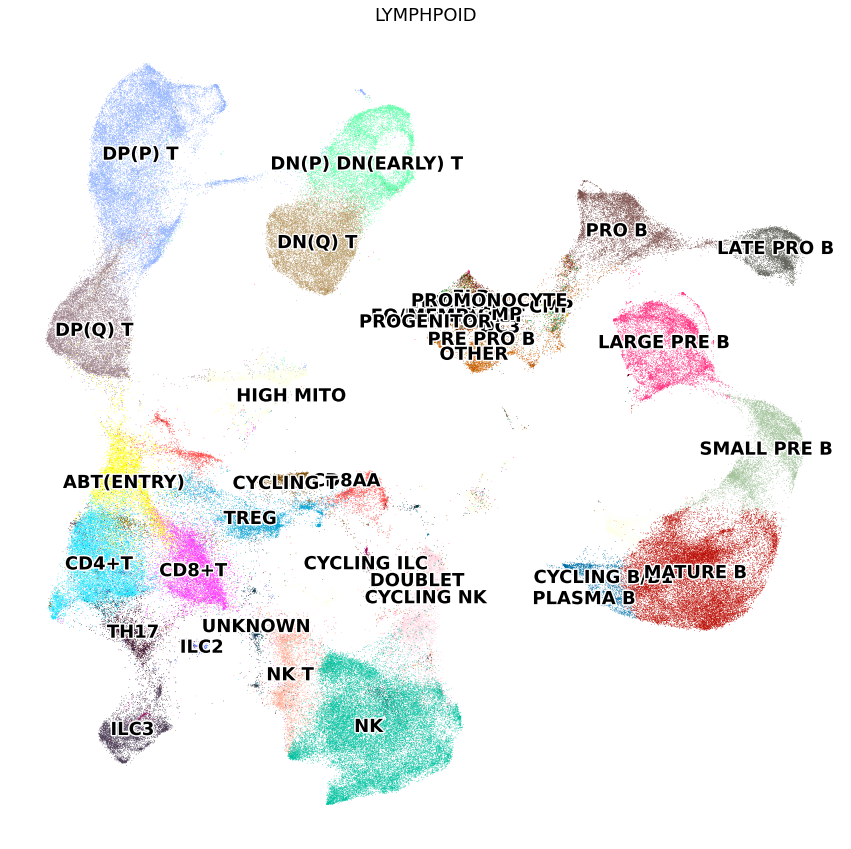

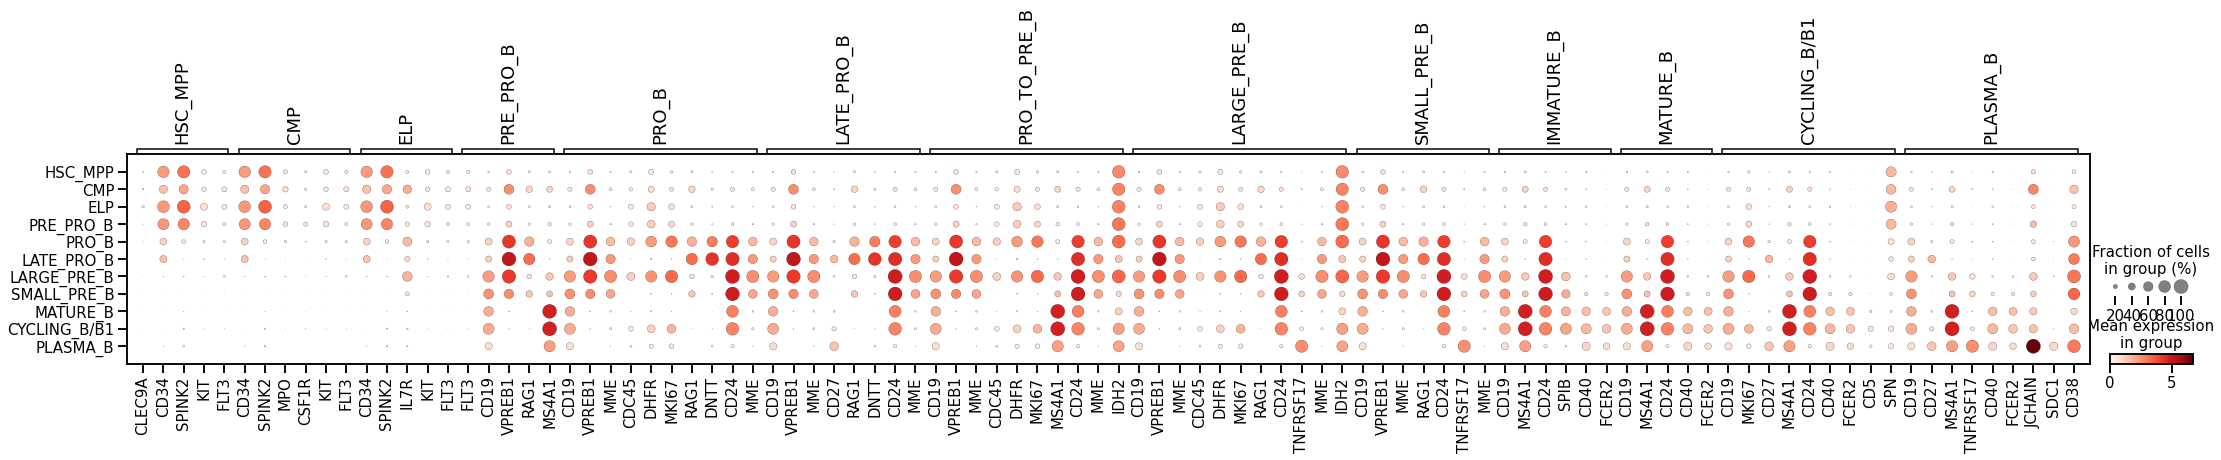

In [731]:
_plot_split_embedding(spl_adata, "LYMPHPOID")
_plot_marker_dotplot(spl_adata, ["B"])
# _plot_markers_embedding(spl_adata, ["B"])

### Myeloid cells

In [732]:
spl_adata = _load_split("MYELOID")

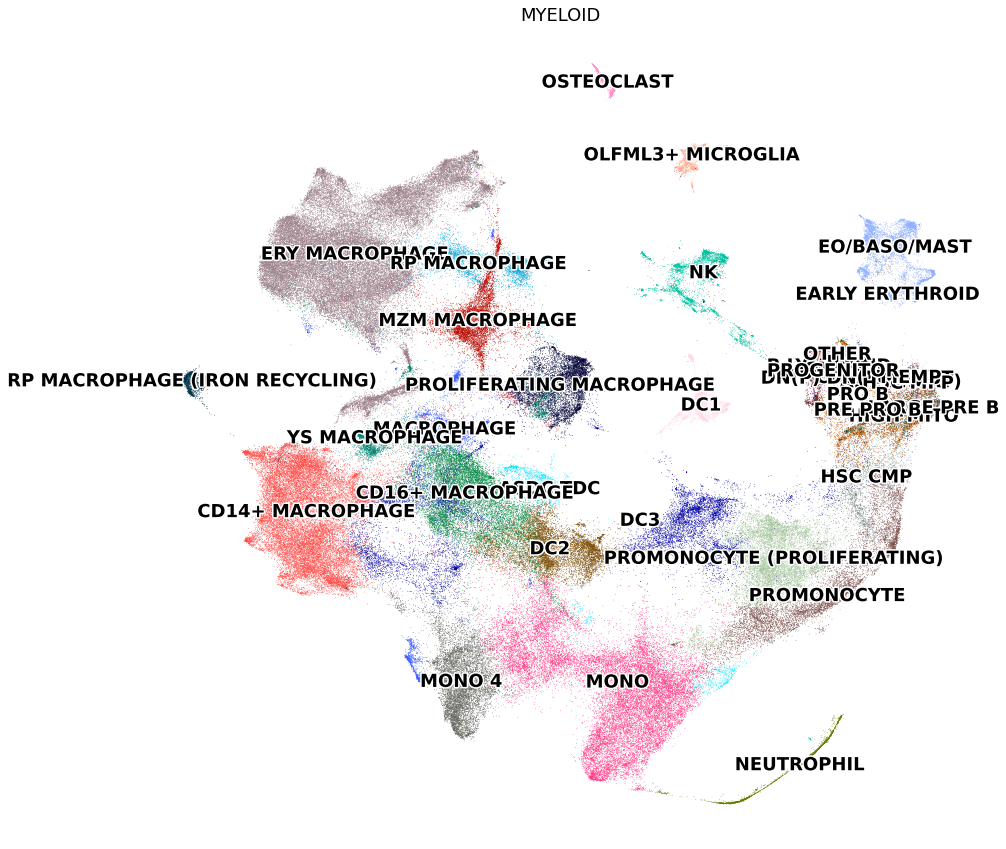

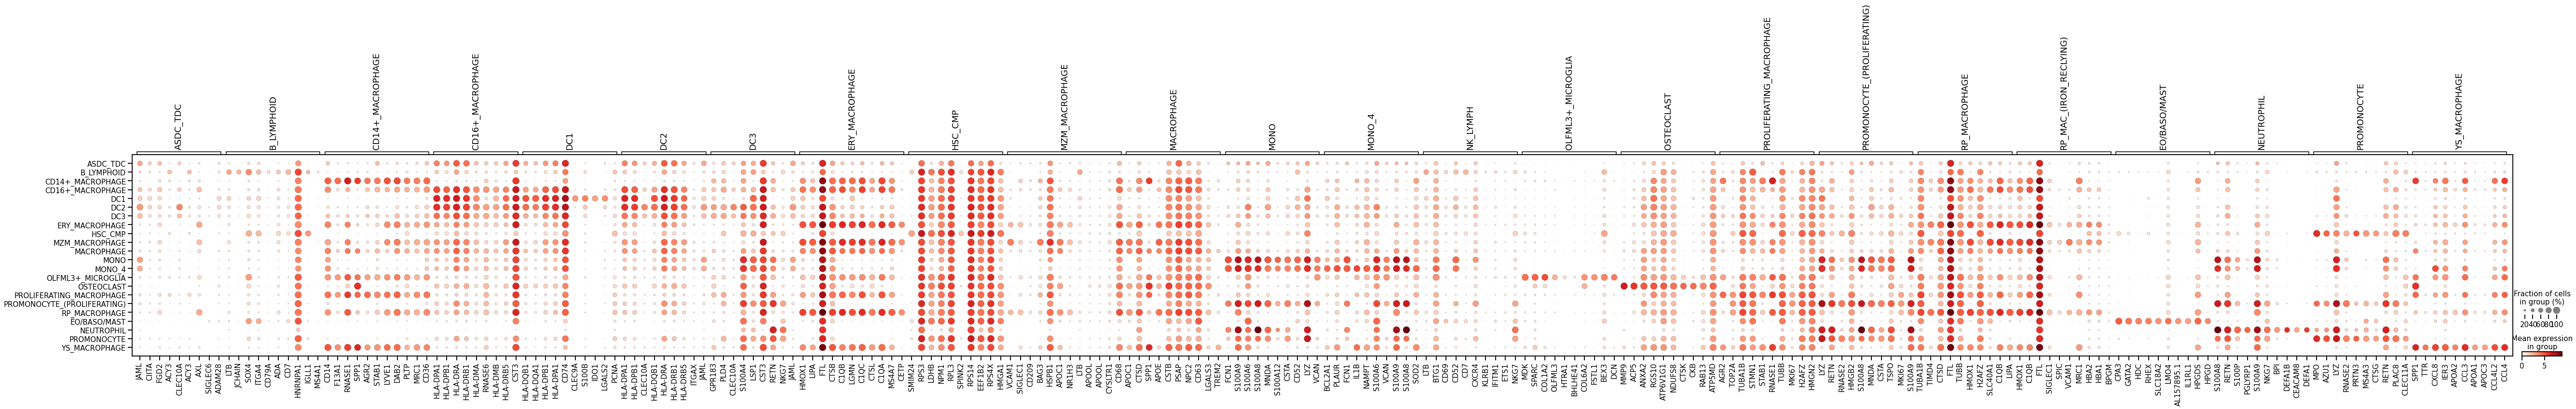

In [733]:
_plot_split_embedding(spl_adata, "MYELOID")
_plot_marker_dotplot(spl_adata, ["MYELOID"])
# _plot_markers_embedding(spl_adata, ["MYELOID"])

### Erythroid cells

In [671]:
spl_adata = _load_split("MEM_PROGENITORS")

AnnDataReadError: Above error raised while reading key '/var' of type <class 'h5py._hl.group.Group'> from /.

In [ ]:
_plot_split_embedding(spl_adata, "ERYTHROID/MK")
_plot_marker_dotplot(spl_adata, ["MEM_PROGENITORS"])

### Save annotations 

In [725]:
adata.obs.to_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp))

---

## Outstanding issues
- "Progenitors"
- left over B_LYMPHOID
- Missing annotations for Ery subsets
